In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import spacy
import re

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from spacy.tokenizer import Tokenizer
from spacy.matcher import Matcher
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
from collections import Counter


In [ ]:
# define function for feature engineering of word count and character count
def word_count(text):
    return len(text.split())

def char_count(text):
    return len(text)

def ngrams(token, sep=' ', n=2, stopwords=stopwords):
    return [sep.join(ngram) for ngram in zip(*[token[i:] for i in range(n)]) 
            if len([t for t in ngram if t in stopwords])==0]

def count_words(df, column='tokens', preprocess=None, min_freq=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    
    counter = Counter()
    df[column].map(update)
    
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

def custom_tokenizer(nlp):
 # use default patterns except the ones matched by re.search
    prefixes = [pattern for pattern in nlp.Defaults.prefixes
                if pattern not in ['-', '_', '#']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes
                if pattern not in ['_']]
    infixes = [pattern for pattern in nlp.Defaults.infixes
               if not re.search(pattern, 'xx-xx')]
    return Tokenizer(vocab = nlp.vocab,
                     rules = nlp.Defaults.tokenizer_exceptions,
                     prefix_search = compile_prefix_regex(prefixes).search,
                     suffix_search = compile_suffix_regex(suffixes).search,
                     infix_finditer = compile_infix_regex(infixes).finditer,
                     token_match = nlp.Defaults.token_match)

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
# read info csv prepared in 1_yt_stats_scraper.ipynb 
df_info = pd.read_csv('data/vid_info_final.csv')

# read caption csv prepared in 2_yt_caption_scraper.ipynb
df_caption = pd.read_csv('data/vid_caption_final.csv')

In [ ]:
# filter publish date with 2023
df_info[df_info['publish_date'].str.contains('2023')]['publish_date']

In [ ]:
# parse publish_date column to datetime format with strptime %d/%m/%Y
df_info['publish_date'] = df_info['publish_date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y')) 


In [ ]:
# check if date has been parsed correctly
df_info['publish_date'].max()

In [ ]:
# create id by extracting unique id from url. This is to merge the two dataframes
df_info['id'] = df_info['url'].apply(lambda x: x.split("=")[-1])
df_info['id'] = df_info['id'].str.split('/').str[-1]

In [ ]:
df_info.shape

In [ ]:
df_info.isna().sum()

In [ ]:
# number of row with no caption/subtitle
print(len(df_caption[df_caption['caption']=='subtitle disabled']))

# filter out row with no caption/subtitle
df_caption_no_na = df_caption[df_caption['caption']!='subtitle disabled']

# feature engineering

In [ ]:
info_text_cols = ['title', 'description']

# create new columns for word count and character count for title and description
for col in info_text_cols:
    # handle missing values
    df_info[col+'_char_count'] = df_info[col].apply(lambda x: char_count(x) if type(x) == str else 0)
    df_info[col+'_word_count'] = df_info[col].apply(lambda x: word_count(x) if type(x) == str else 0)

In [ ]:
caption_text_cols = ['caption']

# create new columns for word count and character count for caption
for col in caption_text_cols:
    # handle missing values which have string 'subtitle disabled'
    df_caption_no_na[col+'_char_count'] = df_caption_no_na[col].apply(lambda x: char_count(x) if x != 'subtitle disabled' and type(x) == str else 0)
    df_caption_no_na[col+'_word_count'] = df_caption_no_na[col].apply(lambda x: word_count(x) if x != 'subtitle disabled' and type(x) == str else 0)

In [ ]:
# create columns days between publish date and last video publish date by author need to sort by author and publish date
df_info.sort_values(by=['author', 'publish_date'], inplace=True)
df_info['days_since_last_video'] = df_info.groupby('author')['publish_date'].diff().dt.days

# fill days since last video na with 0
df_info['days_since_last_video'].fillna(0, inplace=True)

In [ ]:
# create columns days since first video publish date by author need to sort by author and publish date
df_info.sort_values(by=['author', 'publish_date'], inplace=True)
df_info['days_since_first_video'] = df_info.groupby('author')['publish_date'].apply(lambda x: x - x.min()).dt.days

In [ ]:
# create column keyword count and if there is keywords
df_info['keyword_count'] = df_info['keywords'].apply(lambda x: len(x.split(',')) if type(x) == str else 0)
df_info['has_keyword'] = df_info['keyword_count'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
df_info.to_csv('data/df_info.csv', index=False)
df_caption_no_na.to_csv('data/df_caption_no_na.csv', index=False)

# load nlp model

In [ ]:
# load spacy 
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
nlp.tokenizer = custom_tokenizer(nlp)

# increase nlp.max_length to handle long text
nlp.max_length = 1500000

In [ ]:
# apply nlp to title and description
df_info['title_nlp'] = df_info['title'].apply(nlp)

df_info['description_nlp'] = df_info['description'].apply(lambda x: nlp(x) if type(x) == str else '' )

In [ ]:
df_info.columns

In [ ]:
df_caption_no_na['caption_nlp'] = df_caption_no_na['caption'].apply(lambda x: nlp(x) if type(x) == str else '' )

# single word count

In [ ]:
# create token column by filtering out token of interest
df_info['title_token'] = df_info['title_nlp'].apply(lambda x: [token.lemma_.lower() for token in x if token.is_alpha and not token.is_stop])

df_info['description_token'] = df_info['description_nlp'].apply(lambda x: [token.lemma_.lower() for token in x if token.is_alpha and not token.is_stop])

df_caption_no_na['caption_token'] = df_caption_no_na['caption_nlp'].apply(lambda x: [token.lemma_.lower() for token in x if token.is_alpha and not token.is_stop])
df_caption_no_na['caption_noun_token'] = df_caption_no_na['caption_nlp'].apply(lambda x: [token.lemma_.lower() for token in x if token.is_alpha and not token.is_stop and token.pos_ == 'NOUN'])
df_caption_no_na['caption_noun_adj_verbs_token'] = df_caption_no_na['caption_nlp'].apply(lambda x: [token.lemma_.lower() for token in x if token.is_alpha and not token.is_stop and token.pos_ in ['NOUN', 'ADJ', 'VERB']])

In [ ]:
# export to csv for further analysis (wordcloud, topic modelling, etc.)
df_info.to_csv('data/df_info_nlp.csv', index=False)
df_caption_no_na.to_csv('data/df_caption_nlp.csv', index=False)

In [ ]:
# single word count
df_info_title_count_words = count_words(df_info, 'title_token')
df_info_title_count_words.to_csv('data/nlp_output/title_count_words.csv', index=True)

df_info_description_count_words = count_words(df_info, 'description_token')
df_info_description_count_words.to_csv('data/nlp_output/description_count_words.csv', index=True)

df_caption_count_words = count_words(df_caption_no_na, 'caption_token')
df_caption_count_words.to_csv('data/nlp_output/caption_count_words.csv', index=True)

df_caption_count_noun_words = count_words(df_caption_no_na, 'caption_noun_token')
df_caption_count_noun_words.to_csv('data/nlp_output/caption_count_noun_words.csv', index=True)

df_caption_count_noun_adj_verbs_words = count_words(df_caption_no_na, 'caption_noun_adj_verbs_token')
df_caption_count_noun_adj_verbs_words.to_csv('data/nlp_output/caption_count_noun_adj_verbs_words.csv', index=True)

df_info_title_count_words = pd.read_csv('data/nlp_output/title_count_words.csv')
df_info_description_count_words = pd.read_csv('data/nlp_output/description_count_words.csv')
df_caption_count_words = pd.read_csv('data/nlp_output/caption_count_words.csv')
df_caption_count_noun_words = pd.read_csv('data/nlp_output/caption_count_noun_words.csv')
df_caption_count_noun_adj_verbs_words = pd.read_csv('data/nlp_output/caption_count_noun_adj_verbs_words.csv')

<AxesSubplot:xlabel='token', ylabel='freq'>

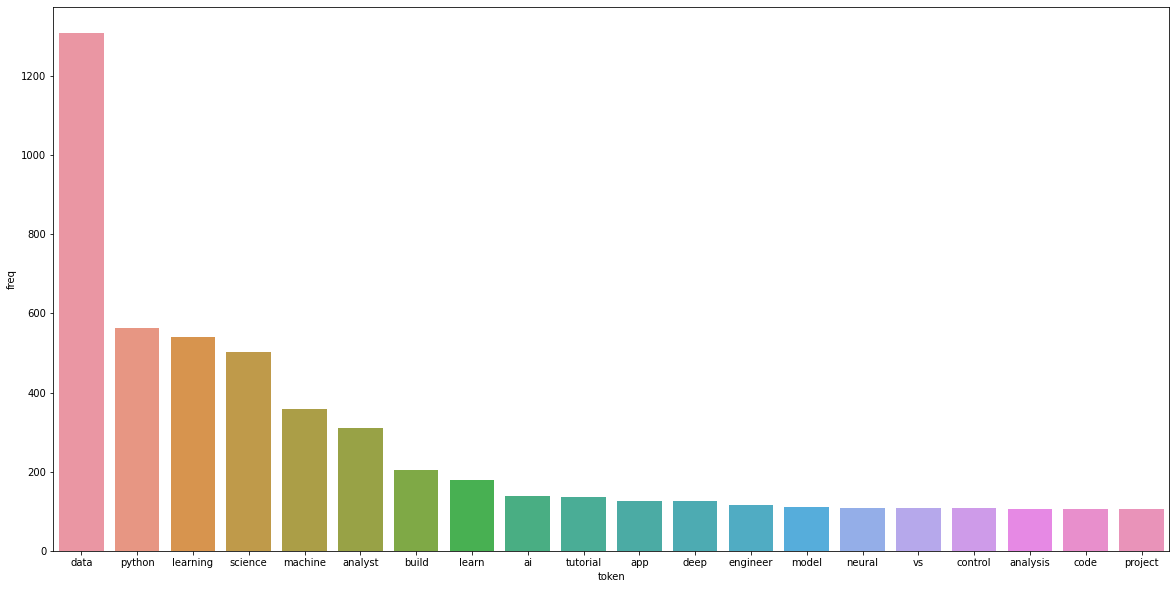

In [9]:
# single word count for title
df_info_title_count_words.reset_index(inplace=True)
# plot top 20 words in barchart in seaborn for df_info_title_count_words
plt.figure(figsize=(20,10))
sns.barplot(x='token', y='freq', data=df_info_title_count_words[:20])
plt.title('Top 20 words in title')

<AxesSubplot:xlabel='token', ylabel='freq'>

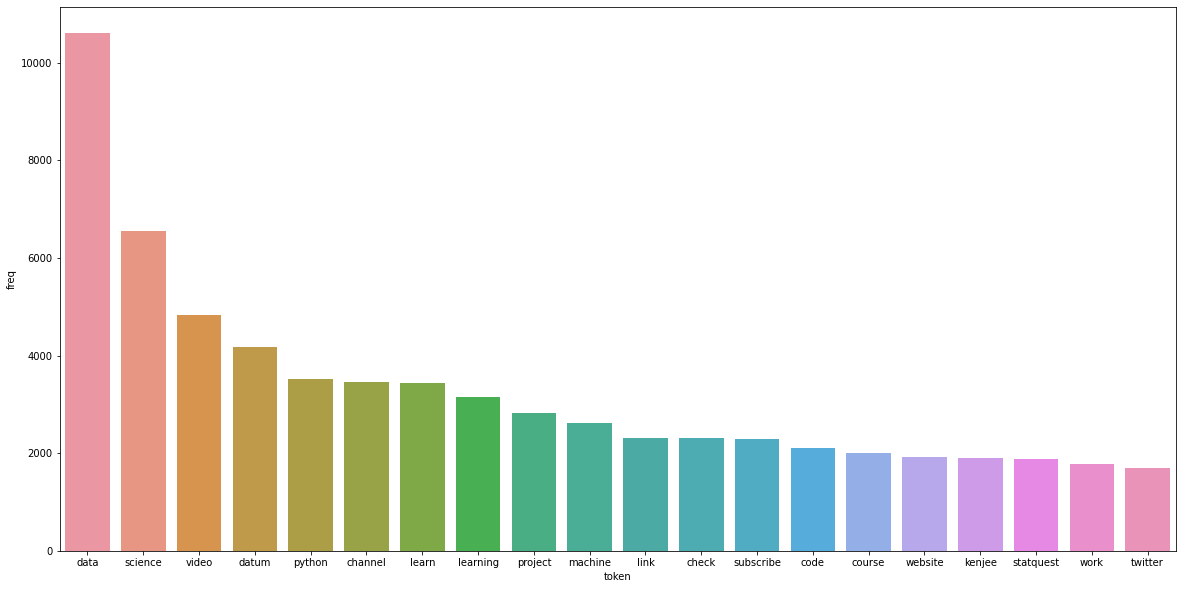

In [10]:
# single word count for description
df_info_description_count_words.reset_index(inplace=True)
# plot top 20 words in barchart in seaborn for df_info_description_count_words
plt.figure(figsize=(20,10))
sns.barplot(x='token', y='freq', data=df_info_description_count_words[:20])
plt.title('Top 20 words in description')

Text(0.5, 1.0, 'Top 20 words in caption')

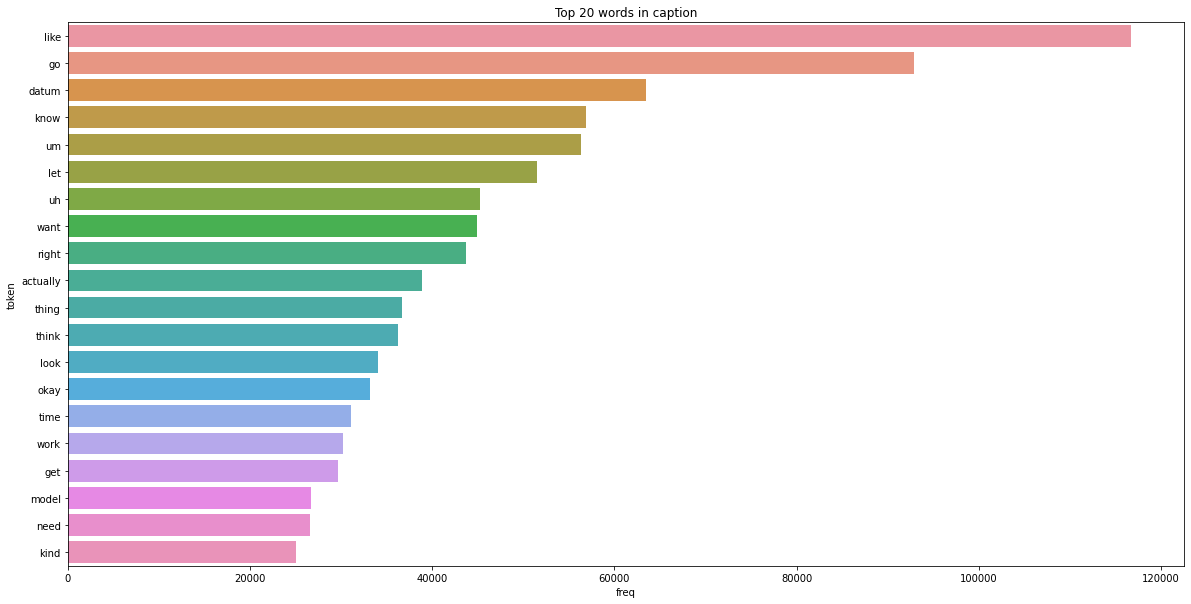

In [11]:
# single word count for caption 
df_caption_count_words.reset_index(inplace=True)
# plot top 20 words in barchart in seaborn for df_caption_count_words
plt.figure(figsize=(20,10))
sns.barplot(x='freq', y='token', data=df_caption_count_words[:20], orient='h')
plt.title('Top 20 words in caption')

Text(0.5, 1.0, 'Top 20 noun words in caption')

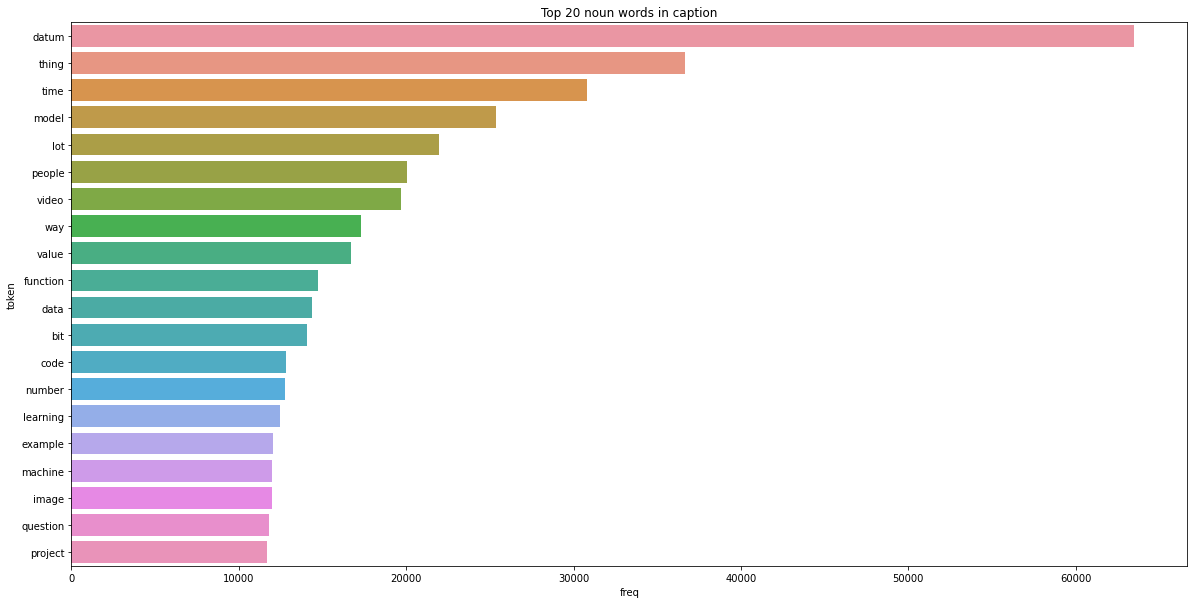

In [12]:
# single word count for caption noun
df_caption_count_noun_words.reset_index(inplace=True)
# plot top 20 words in barchart in seaborn for df_caption_count_noun_words
plt.figure(figsize=(20,10))
sns.barplot(x='freq', y='token', data=df_caption_count_noun_words[:20], orient='h')
plt.title('Top 20 noun words in caption')

Text(0.5, 1.0, 'Top 20 noun, adj, verbs words in caption')

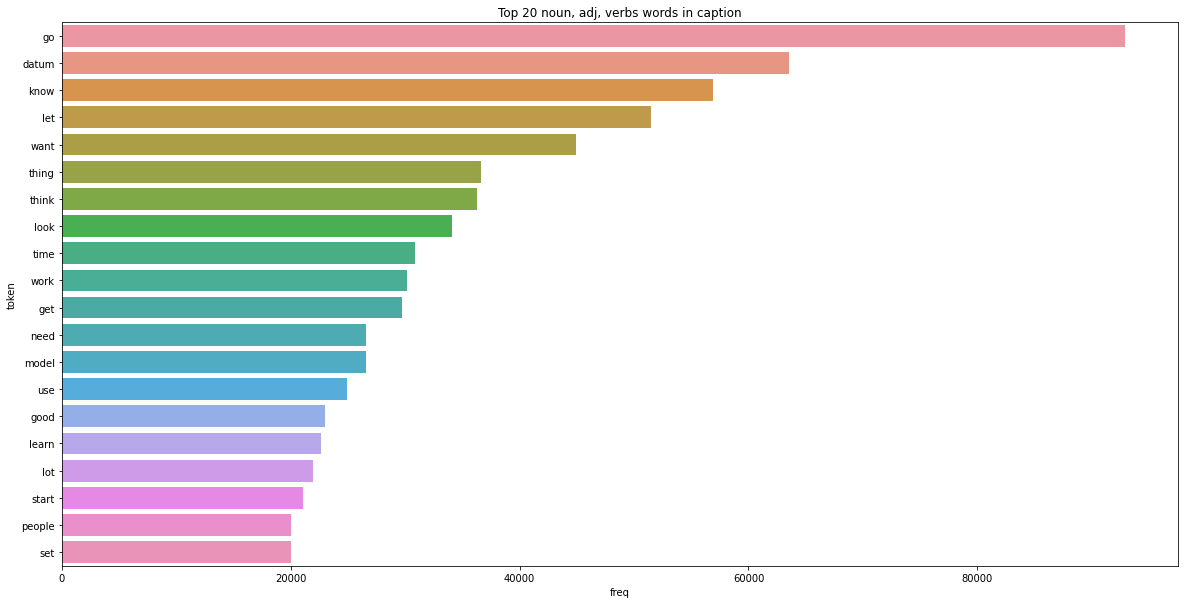

In [13]:
# single word count for caption noun adj verbs
df_caption_count_noun_adj_verbs_words.reset_index(inplace=True)
# plot top 20 words in barchart in seaborn for df_caption_count_noun_adj_verbs_words
plt.figure(figsize=(20,10))
sns.barplot(x='freq', y='token', data=df_caption_count_noun_adj_verbs_words[:20], orient='h')
plt.title('Top 20 noun, adj, verbs words in caption')

# N-grams analysis 

In [ ]:
# create column with bigram and trigram
df_info['title_bigram'] = df_info['title_token'].apply(ngrams, n=2)
df_info['title_trigram'] = df_info['title_token'].apply(ngrams, n=3)

df_info['description_bigram'] = df_info['description_token'].apply(ngrams, n=2)
df_info['description_trigram'] = df_info['description_token'].apply(ngrams, n=3)

In [ ]:
# word count and export bigram and trigram

ngrams_col = ['title_bigram', 'title_trigram', 'description_bigram', 'description_trigram']

for ngrams in ngrams_col:
    count_words(df_info, ngrams).to_csv(f'data/nlp_output/{ngrams}.csv')


In [ ]:
# create column with bigram and trigram for caption
df_caption_no_na['caption_bigram'] = df_caption_no_na['caption_token'].apply(ngrams, n=2)
df_caption_no_na['caption_trigram'] = df_caption_no_na['caption_token'].apply(ngrams, n=3)

# create column with bigram and trigram for caption noun
df_caption_no_na['caption_noun_bigram'] = df_caption_no_na['caption_noun_token'].apply(ngrams, n=2)
df_caption_no_na['caption_noun_trigram'] = df_caption_no_na['caption_noun_token'].apply(ngrams, n=3)

In [ ]:
# create column with bigram and trigram for caption noun adj verbs
df_caption_count_noun_adj_verbs_bigram = df_caption_no_na['caption_noun_adj_verbs_token'].apply(ngrams, n=2)
df_caption_count_noun_adj_verbs_trigram = df_caption_no_na['caption_noun_adj_verbs_token'].apply(ngrams, n=3)


In [ ]:

# word count and export bigram and trigram for caption

ngrams_col = ['caption_bigram', 'caption_trigram', 'caption_noun_bigram', 'caption_noun_trigram']

for ngrams in ngrams_col:
    count_words(df_caption_no_na, ngrams).to_csv(f'data/nlp_output/{ngrams}.csv')

In [3]:
# read all bigram and trigram csv
df_info_title_bigram = pd.read_csv('data/nlp_output/title_bigram.csv')
df_info_title_trigram = pd.read_csv('data/nlp_output/title_trigram.csv')

df_info_description_bigram = pd.read_csv('data/nlp_output/description_bigram.csv')
df_info_description_trigram = pd.read_csv('data/nlp_output/description_trigram.csv')

df_caption_bigram = pd.read_csv('data/nlp_output/caption_bigram.csv')
df_caption_trigram = pd.read_csv('data/nlp_output/caption_trigram.csv')

df_caption_noun_bigram = pd.read_csv('data/nlp_output/caption_noun_bigram.csv')
df_caption_noun_trigram = pd.read_csv('data/nlp_output/caption_noun_trigram.csv')

Text(0.5, 1.0, 'Top 20 Trigram in Title')

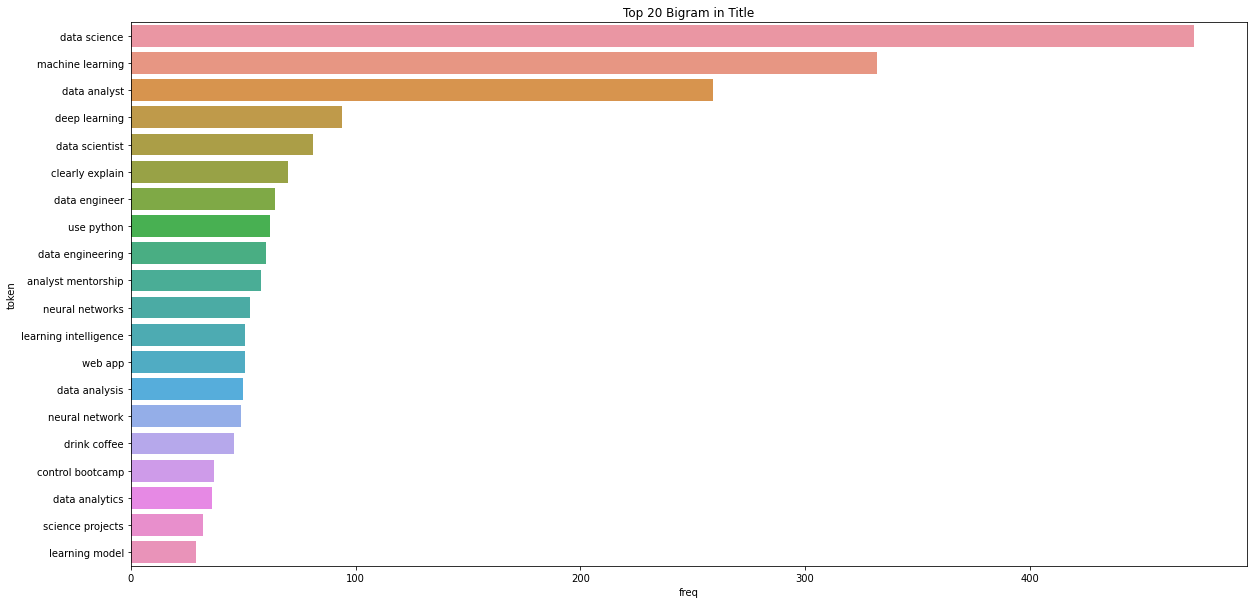

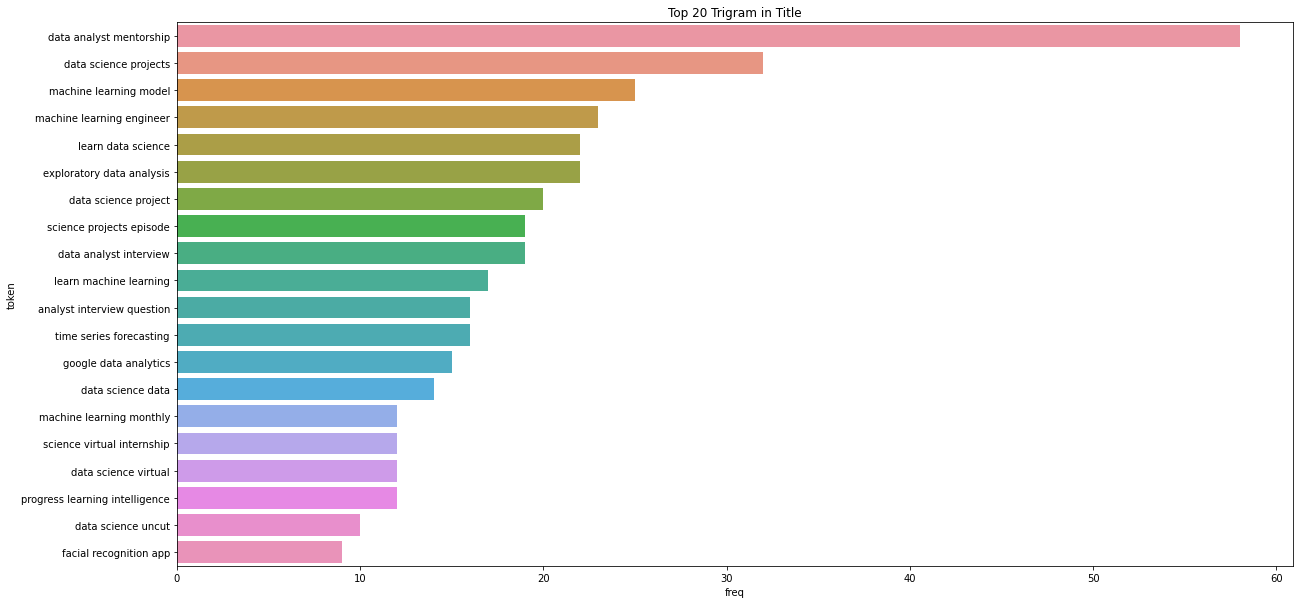

In [4]:
# plot top 20 bigram in horizontal barchart in seaborn for df_info_title_bigram
plt.figure(figsize=(20,10))
sns.barplot(x='freq', y='token', data=df_info_title_bigram[:20], orient='h')
plt.title('Top 20 Bigram in Title')

# plot top 20 trigram in horizontal barchart in seaborn for df_info_title_trigram
plt.figure(figsize=(20,10))
sns.barplot(x='freq', y='token', data=df_info_title_trigram[:20], orient='h')
plt.title('Top 20 Trigram in Title')

Text(0.5, 1.0, 'Top 20 Trigram in Description')

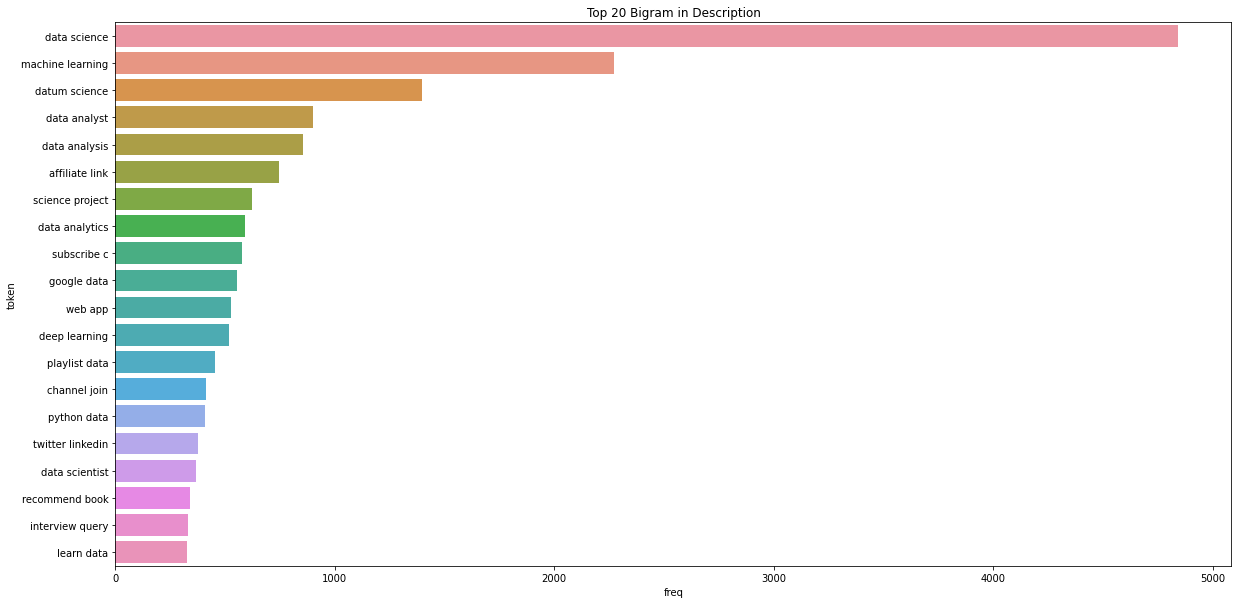

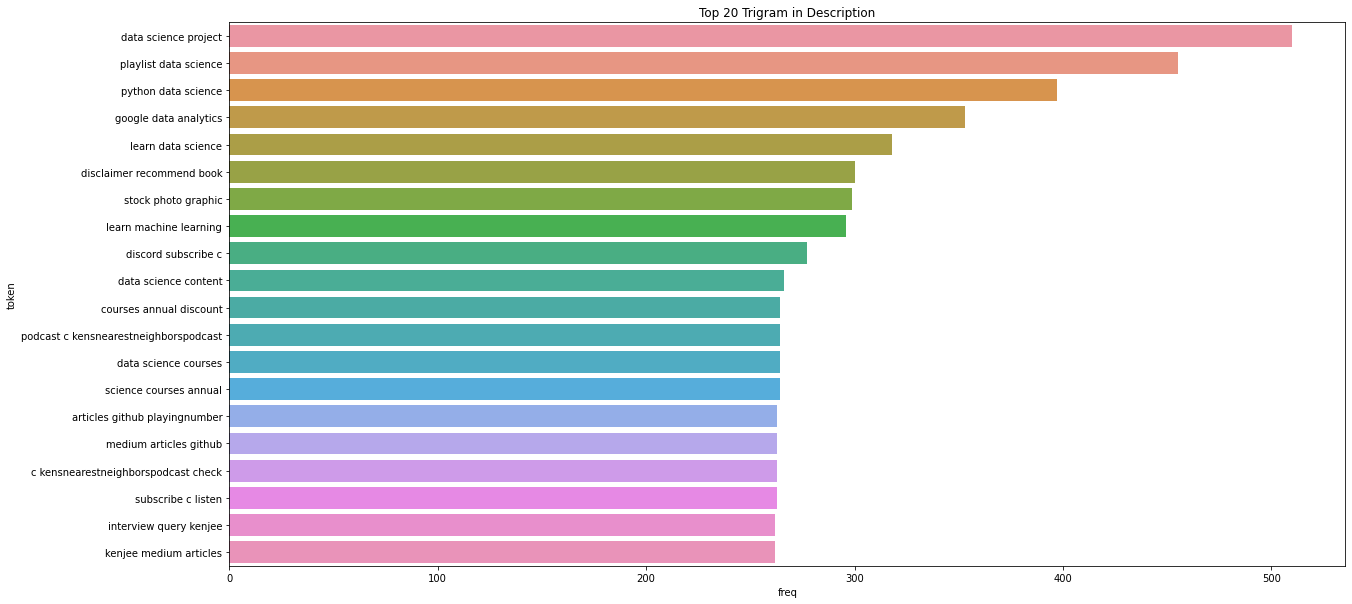

In [5]:
# plot top 20 bigram in horizontal barchart in seaborn for df_info_description_bigram
plt.figure(figsize=(20,10))
sns.barplot(x='freq', y='token', data=df_info_description_bigram[:20], orient='h')
plt.title('Top 20 Bigram in Description')

# plot top 20 trigram in horizontal barchart in seaborn for df_info_description_trigram
plt.figure(figsize=(20,10))
sns.barplot(x='freq', y='token', data=df_info_description_trigram[:20], orient='h')
plt.title('Top 20 Trigram in Description')

Text(0.5, 1.0, 'Top 20 Trigram in Caption')

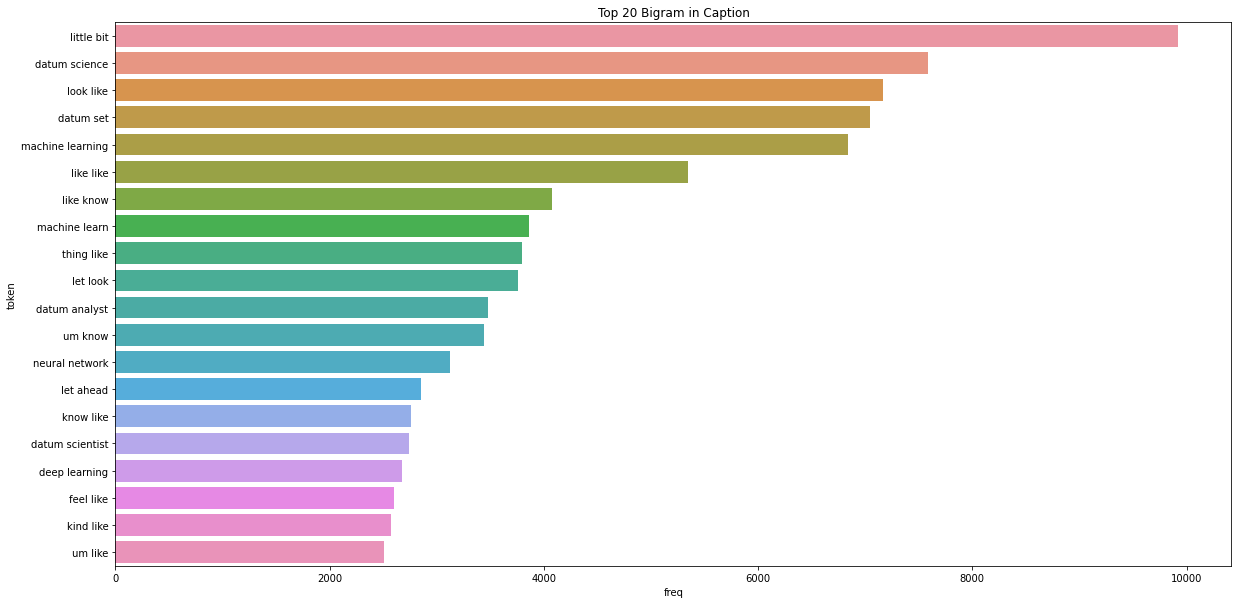

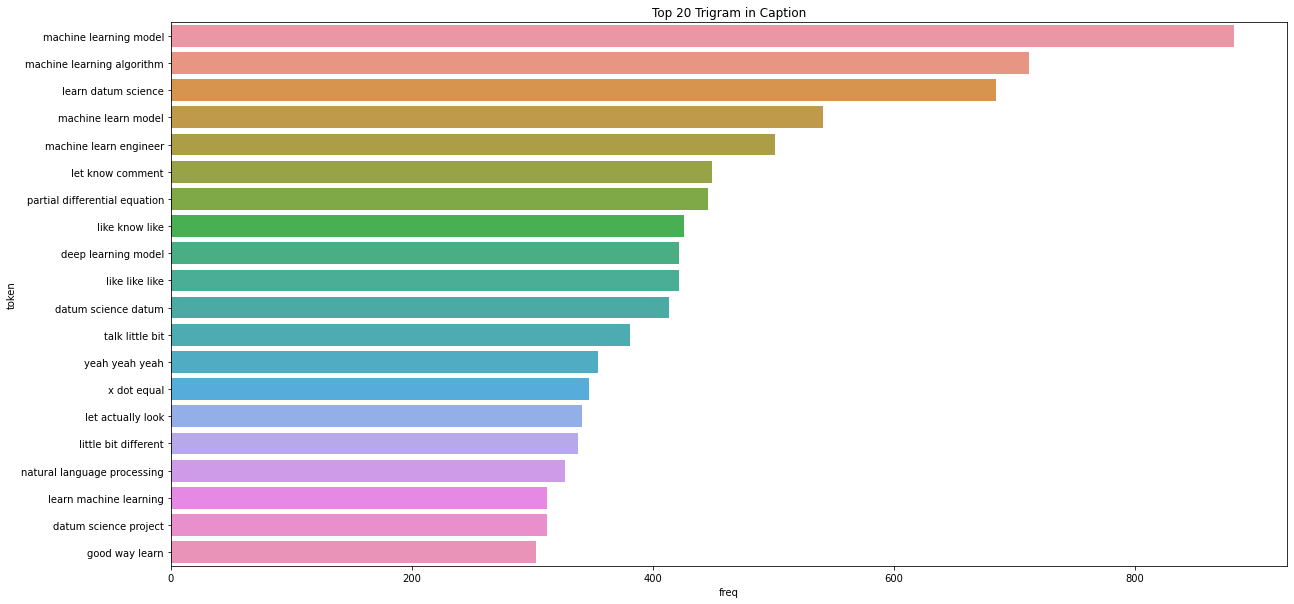

In [6]:
# plot top 20 bigram in horizontal barchart in seaborn for df_caption_bigram
plt.figure(figsize=(20,10))
sns.barplot(x='freq', y='token', data=df_caption_bigram[:20], orient='h')
plt.title('Top 20 Bigram in Caption')

# plot top 20 trigram in horizontal barchart in seaborn for df_caption_trigram
plt.figure(figsize=(20,10))
sns.barplot(x='freq', y='token', data=df_caption_trigram[:20], orient='h')
plt.title('Top 20 Trigram in Caption')

Text(0.5, 1.0, 'Top 20 Trigram in Caption Noun')

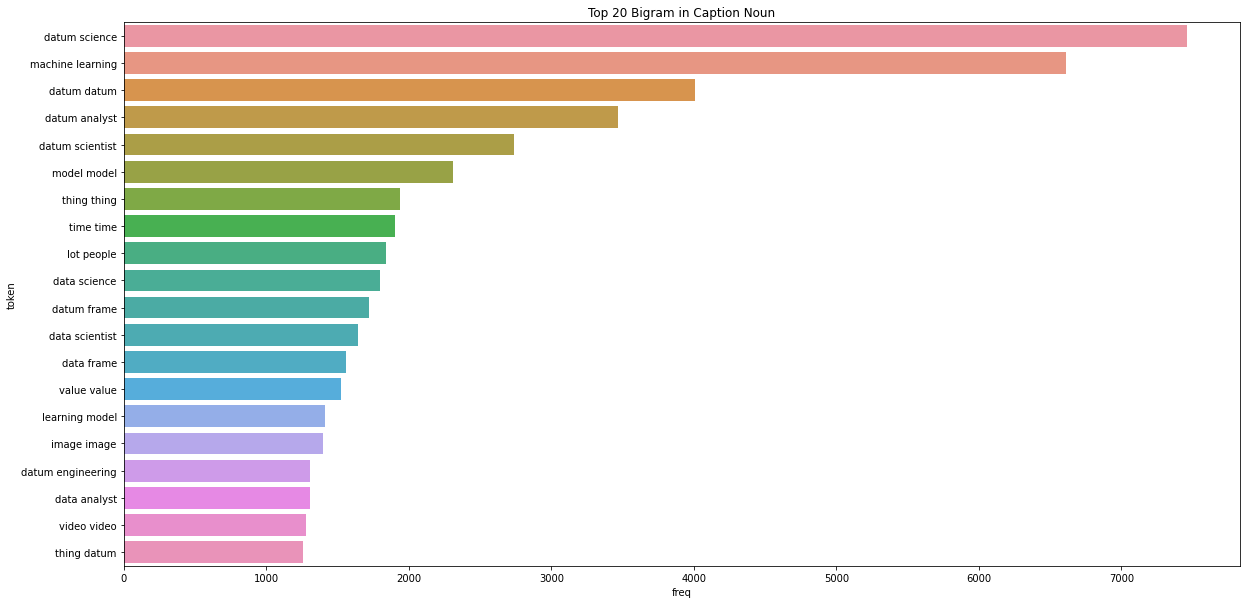

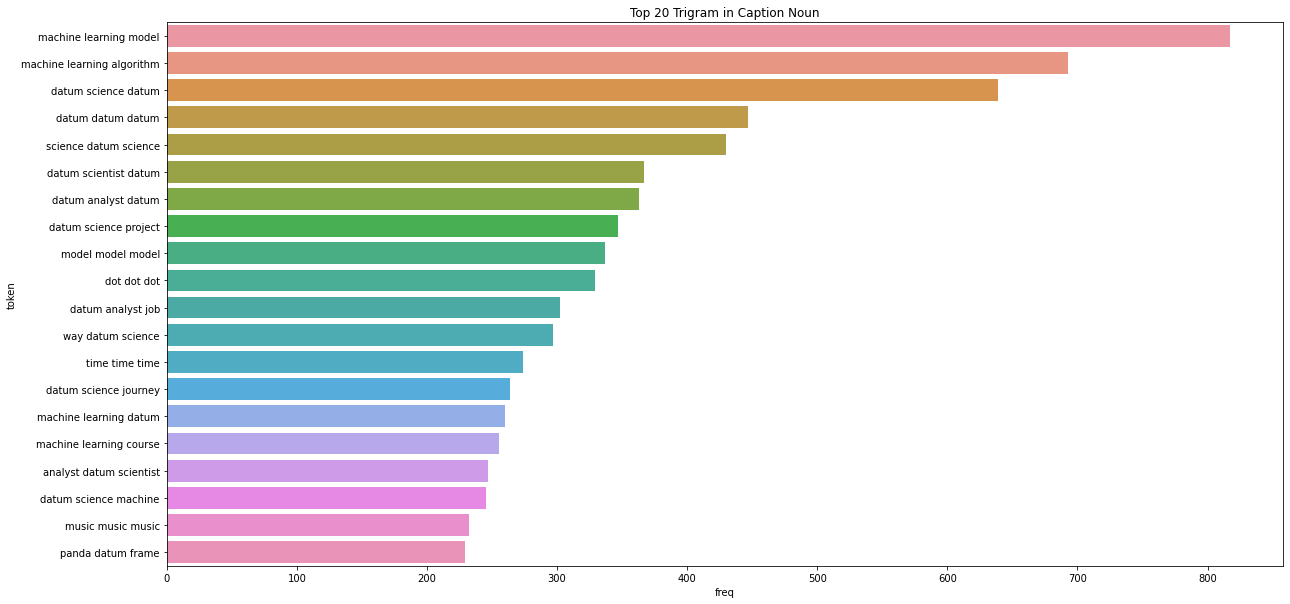

In [7]:
# plot top 20 bigram in horizontal barchart in seaborn for df_caption_noun_bigram
plt.figure(figsize=(20,10))
sns.barplot(x='freq', y='token', data=df_caption_noun_bigram[:20], orient='h')
plt.title('Top 20 Bigram in Caption Noun')

# plot top 20 trigram in horizontal barchart in seaborn for df_caption_noun_trigram
plt.figure(figsize=(20,10))
sns.barplot(x='freq', y='token', data=df_caption_noun_trigram[:20], orient='h')
plt.title('Top 20 Trigram in Caption Noun')